# Проект для «Викишоп»

**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 



# Импорт библиотек

In [1]:
!pip install pymystem3
!pip install imblearn

In [2]:
import numpy as np
import pandas as pd

import torch
import transformers

import re

from tqdm import notebook

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords, wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from pymystem3 import Mystem

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE


# Чтение данных и общие сведения

In [3]:
try:
    data = pd.read_csv('/Users/petrsilov/Desktop/Diplom/sem_8/toxic_comments.csv')
    print('ok')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
    print('also ok')

In [4]:
# data = pd.read_csv('/Users/petrsilov/Desktop/Diplom/sem_8/toxic_comments.csv')

In [5]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
def info(df):
    print(df.info())
    print(df.shape)
    print(df.describe())
    if df.isna().values.any():
        print(pd.DataFrame(df.isna().mean.to_frame(name='gaps'))).style.format({'gaps':'{:.2%}'})
    else: print('No gaps')
        
    if df.duplicated().values.any():
        print('true', df.duplicated().value_counts())
    else: print('false')
    print(df.head())
info(data)

In [7]:
data.toxic.value_counts()

# Очистка данных

## лемметизация, токенизция

In [8]:
%%time
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(lemmatizer.lemmatize(text, get_wordnet_pos(text)))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

data['lemm_text'] = data['text'].apply(lemmatize_text)

In [9]:
data['lemm_text'][100], data['text'][100]

## CountVectorizer

In [10]:
stopwords = list(nltk_stopwords.words('english'))

vector_wb = CountVectorizer(stop_words=stopwords)


In [11]:
X = data.lemm_text
y = data.toxic

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1234)

(X_train.count() / X.count() * 100).round(), (X_test.count() / X.count() * 100).round()

In [13]:
X_train_wb = vector_wb.fit_transform(X_train)
X_test_wb = vector_wb.transform(X_test)

X_train_wb.shape, X_test_wb.shape

## кросс валидация на CountVectorizer

In [14]:
lr_model = LogisticRegression()

train_f1 = cross_val_score(lr_model, 
                      X_train_wb, 
                      y_train, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

In [15]:
lr_model_balanced = LogisticRegression(class_weight='balanced')

train_f1_balanced = cross_val_score(lr_model_balanced, 
                      X_train_wb, 
                      y_train, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 на CV', train_f1_balanced)

In [16]:
%%time
kf = KFold(n_splits=5, random_state=None, shuffle=False)
imba_pipeline = make_pipeline(SMOTE(random_state=1234), 
                              LogisticRegression(random_state=1234))
cross_val_score(imba_pipeline, X_train_wb, y_train, scoring='f1', cv=kf).mean()


## TfidfVectorizer

In [17]:
vector_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [18]:
X_train_tf_idf = vector_tf_idf.fit_transform(X_train)
X_test_tf_idf = vector_tf_idf.transform(X_test)

X_train_tf_idf.shape, X_test_tf_idf.shape

In [19]:
lr_model_tf_idf = LogisticRegression()

train_f1_tf_idf = cross_val_score(lr_model_tf_idf, 
                      X_train_tf_idf, 
                      y_train, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 на CV', train_f1_tf_idf)

In [20]:
lr_model_balanced_tf_idf = LogisticRegression(class_weight='balanced')

train_f1_balanced_tf_idf = cross_val_score(lr_model_balanced_tf_idf, 
                      X_train_tf_idf, 
                      y_train, 
                      cv=3, 
                      scoring='f1').mean()
print('F1 на CV', train_f1_balanced_tf_idf)

- После проверки разных вариантов эмбединга я выделил некоторые варинты для будующего обучения:
    - countvector
    - TF-IDF
    
    - upsample и downsample решил не использовать

# Подбор гипер параметров и обучение

## Logisticregressor CountVectorizer

In [21]:
%%time
lr_classifier = LogisticRegression(random_state=1234)
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10]}]



rs_lr = GridSearchCV(lr_classifier, params, scoring='f1',cv=3, n_jobs=-1)


model_random_lr = rs_lr.fit(X_train_wb,y_train)

best_params_lr = model_random_lr.best_params_
best_score_lr = model_random_lr.best_score_

# random random search results
print('Best random search hyperparameters are: '+str(best_params_lr))
print('Best random search score is: '+str(best_score_lr))

## DecisionTreeClassifier CountVectorizer

In [23]:
%%time 
dtc_classificator = DecisionTreeClassifier(random_state=1234)
params = [{'max_depth':[x for x in range(50,100,10)],
                'min_samples_split' : [2, 4, 6]}]


clf_dtc = GridSearchCV(dtc_classificator, params, scoring='f1',cv=3, n_jobs=-1)

model_dtc = clf_dtc.fit(X_train_wb,y_train)

best_params_dtc = model_dtc.best_params_
best_score_dtc = model_dtc.best_score_

# random random search results
print('Best random search hyperparameters are: '+str(best_params_dtc))
print('Best random search score is: '+str(best_score_dtc))

## LogisticRegression TD-IDF

In [25]:
%%time
lr_tf_idf_classifier = LogisticRegression(random_state=1234)
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10]}]



rs_lr_tf_idf = GridSearchCV(lr_tf_idf_classifier, params, scoring='f1',cv=3, n_jobs=-1)


model_random_lr_tf_idf = rs_lr_tf_idf.fit(X_train_tf_idf,y_train)

best_params_lr_tf_idf = model_random_lr_tf_idf.best_params_
best_score_lr_tf_idf = model_random_lr_tf_idf.best_score_

# random random search results
print('Best random search hyperparameters are: '+str(best_params_lr_tf_idf))
print('Best random search score is: '+str(best_score_lr_tf_idf))

In [26]:
classificator_lr_tf_idf = LogisticRegression(random_state=1234)
classificator_lr_tf_idf.set_params(**best_params_lr_tf_idf)
classificator_lr_tf_idf.fit(X_train_tf_idf, y_train)
target_predict_tf_idf = classificator_lr_tf_idf.predict(X_test_tf_idf)
valid_f1_lr_tf_idf = f1_score(y_test, target_predict_tf_idf)

print('f1 на тесте', valid_f1_lr_tf_idf)

## CatBoostClassifier TD-IDF

In [27]:
%%time
classificator_cb = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    iterations=10,
    random_seed = 1234,
    auto_class_weights = 'Balanced',
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"

        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],#,"Sevengram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],#,"Sevengram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],#,"Sevengram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)



params = [{'learning_rate': [0.2]
          , 'verbose' : [50]}]



rs_cb_tf_idf = GridSearchCV(classificator_cb, params, scoring='f1',cv=3, n_jobs=-1)


model_random_cb_tf_idf = rs_cb_tf_idf.fit(X_train_tf_idf,y_train)

best_params_cb_tf_idf = model_random_cb_tf_idf.best_params_
best_score_cb_tf_idf = model_random_cb_tf_idf.best_score_

# random random search results
print('Best random search hyperparameters are: '+str(best_params_cb_tf_idf))
print('Best random search score is: '+str(best_score_cb_tf_idf))

In [40]:
f1_of = pd.DataFrame([best_score_cb_tf_idf, best_score_lr_tf_idf, '-'], columns=['TF-IDF_f1'],\
                            index=['CatBoostClassifier', 'LogisticRegression', 'DecisionTreeClassifier'])
f1_of['Count_Vector_f1'] = ['-', best_score_lr, best_score_dtc]

f1_of

## Bert

In [30]:
%%time
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized = X.apply(
    lambda x: tokenizer.encode(x[0:512], add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)


In [31]:
%%time
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [32]:
config = transformers.BertConfig()
model = transformers.BertModel.from_pretrained(
    'bert-base-uncased', config=config)

- **Вывод**
    - были обучены модели на разных пердобработанных данных
    - модели которые были опробованны 
        - CatBoostClassifier
        - LogisticRegression
        - DecisionTreeClassifier


# Итоги

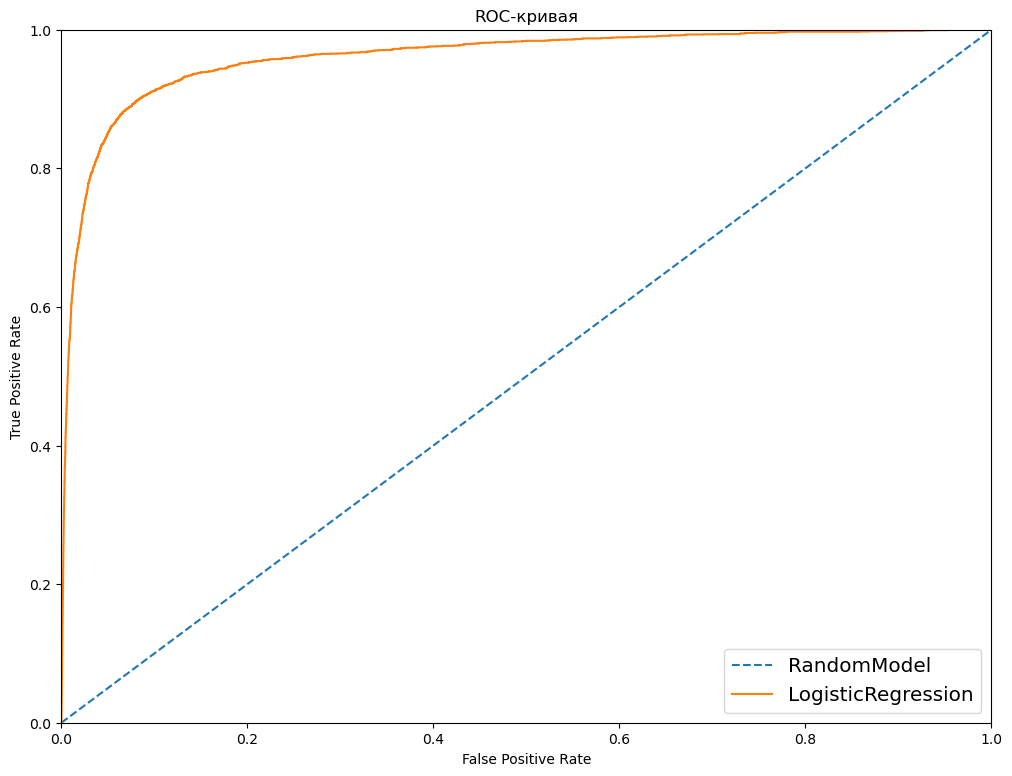

In [41]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')



probabilities_test = classificator_lr_tf_idf.predict_proba(X_test_wb)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.plot(fpr, tpr, label='LogisticRegression')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [42]:
print(f'best f1 score {valid_f1_lr_tf_idf} logistic rergression on tf_idf')

# Вывод


Было прделано:

- Подготовленны данные обучения.

- Выбран способ баланса классов, сформированы обучающая и тестовая выборка.

- Обучены модели и выбрана лучшая из них.

- Показаны параметры качества моделей.

- Нужно было достигнуть качества f1 > 0.75 
- Лучше всего проявила себя LogisticRegression на данных TF-IDF
- Если дать catboost больше итераций мне кажется можно добиться лучшего качетва, но потратим больше времени
